# Importing Packages

In [208]:
import os
import timeit
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import random, vmap, jit
import iris
import iris.coord_categorisation
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC, BarkerMH
import gpflow
from sklearn.metrics import r2_score
import skgstat as skg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("figure", figsize=(10, 10))
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
from mpl_toolkits.basemap import Basemap
from src.model_fitting_functions import lima_model 
from src.model_fitting_functions import BernoulliGamma
from src.plotting_functions import histogram_plot
from src.plotting_functions import bernoulli_gamma_pdf_plot
from src.plotting_functions import lima_alpha_beta_relationship_scatter
from src.netcdf_functions import pcolormesh_basemapplot_cube
from src.netcdf_functions import pcolormesh_basemapplot_data

from IPython.display import display

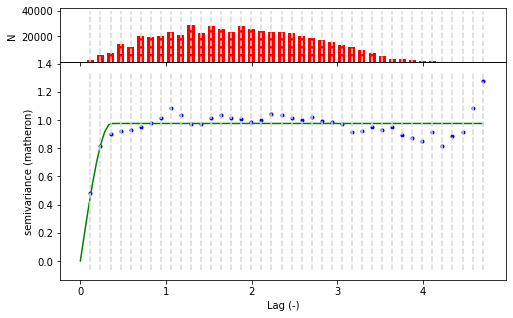

In [164]:
#Plotting Semivariogram of Standardised Alpha values
coords_stand = np.dstack([df_stand['Grid_Latitude'].to_numpy(),df_stand['Grid_Longitude'].to_numpy()]).reshape(-1,2)
alpha_values_stand = df_stand['Alpha'].to_numpy()#.reshape(-1,1)
V_stand = skg.Variogram(coords_stand,alpha_values_stand,n_lags=40)
V_stand.plot()
plt.show()

In [172]:
#Loading parameter sample estimates from MCMC fitting
gp_samples_obj = np.load('/data/notebooks/jupyterlab-biascorrlab/data/AP_Lima_GP_samples.npy',allow_pickle=True)
gp_samples_dict = dict(zip(gp_samples_obj[:,0], gp_samples_obj[:,1]))

Text(0.5, 1.0, 'Semivariogram for GP Fit against Empirical')

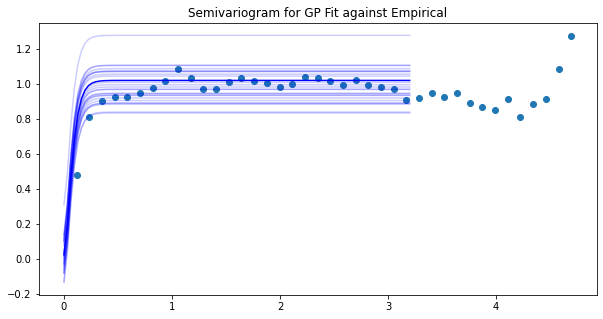

In [178]:
#Plotting semivariogram from MCMC samples of parameter estimates (Semivariance = -Covariance+Kernel Variance + Likelihood Variance)
plt.figure(figsize=(10,5))
xs = np.linspace(0,3.2,100).reshape(-1, 1)
zeros = np.zeros(xs.shape)
for i in np.arange(0,499,20):
    kern_ = gpflow.kernels.Matern32(lengthscales=gp_samples_dict['kernel_lengthscales'][i],variance=gp_samples_dict['kernel_variance'][i])
    latitude_covariances = kern(np.hstack((xs,zeros)))[0]
    kernel_variance = gp_samples_dict['kernel_variance'][i]
    likelihood_variance = gp_samples_dict['likelihood_variance'][i]
    plt.plot(xs,-latitude_covariances+kernel_variance+likelihood_variance,color='b',alpha=0.2)
kern_mean = gpflow.kernels.Matern32(lengthscales=gp_samples_dict['kernel_lengthscales'].mean(axis=0),variance=gp_samples_dict['kernel_variance'].mean(axis=0))
latitude_covariances = kern_mean(np.hstack((xs,zeros)))[0]
kernel_variance_mean = gp_samples_dict['kernel_variance'].mean(axis=0)
likelihood_variance_mean = gp_samples_dict['likelihood_variance'].mean(axis=0)
plt.plot(xs,-latitude_covariances+kernel_variance_mean+likelihood_variance_mean,color='b')
plt.scatter(V_stand.get_empirical()[0],V_stand.get_empirical()[1])
plt.title('Semivariogram for GP Fit against Empirical')

############## 

Need to ask Erick about semivariogram above behaviour - model seems to have underestimated lengthscale (covariance decays too quickly with distance) 
- create list of distances (xs)
- create kernel with sample lengthscale and variance
- evaluate covariance using kernel with an argument consisting of an lat-lon array with of lat values given by the distances (xs) and lon values equal to zero
- evaluate the semivariance as: semivariance = -covariance + kernel variance + likelihood variance

In [215]:
daily_data = np.load('/data/notebooks/jupyterlab-biascorrlab/data/AP_Daily_Snowfall.npy')[:,-2]

Text(0, 0.5, 'Total Daily Snowfall / mmWEq')

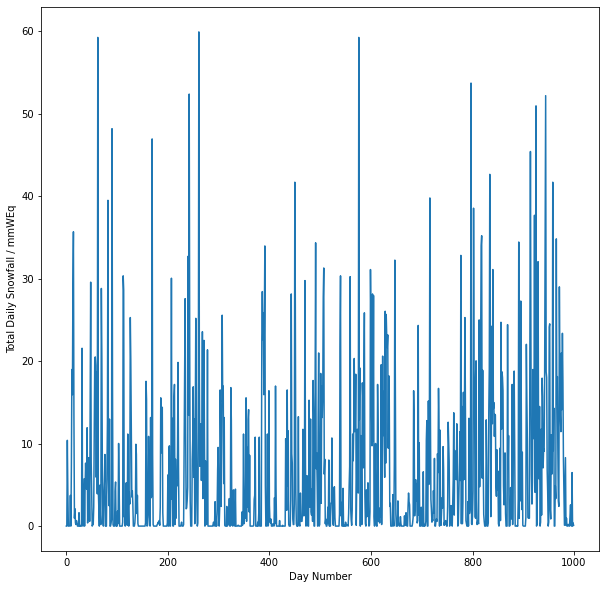

In [217]:
# Example of original data for daily snowfall on month=1 (Feb) and site=10
plt.plot(daily_data[:,500])
plt.xlabel('Day Number')
plt.ylabel('Total Daily Snowfall / mmWEq')

In [220]:
df_hparams

,a0,a1,betavar
0,-5.051933,4.951772,0.339374
1,-5.243973,5.274340,0.274037
2,-4.988688,4.913285,0.299707
3,-5.310406,5.359760,0.330316
4,-4.965867,4.913278,0.321984
...,...,...,...
1995,-5.253967,5.268746,0.335252
1996,-4.988964,4.888391,0.313654
1997,-5.225679,5.291591,0.300897
1998,-5.274940,5.288920,0.305287


In [221]:
alpha = df['Alpha'][500]
a0,a1 = df_hparams['a0'].mean(),df_hparams['a1'].mean()
beta = np.log(a0+a1*alpha)

/tmp/ipykernel_9430/2775082904.py:3: RuntimeWarning: invalid value encountered in log
  beta = np.log(a0+a1*alpha)


In [222]:
a0

-5.143295

In [223]:
a1

5.1202707